# Training ResNet + TTRL on CIFAR-100
This notebook contains the pipeline for training ResNet20 with the last layer substituted by TTRL (implementation can be found in models/ folder) on CIFAR-100 dataset. The training details are as in [Deep Residual Learning for Image Recognition, K. He et al](https://arxiv.org/pdf/1512.03385.pdf) and can be found in the last cell of the notebook.

If you run this notebook as is, it will train five models with different values of theta (see implementation of TTRL for description of what theta is) and save them and some checkpoints in trained_models/ folder.


In [2]:
# !pip install ipywidgets
# !pip install -U tensorly
# !pip install -U tensorly-torch

In [17]:
import tltorch
import torch
from torch import nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR100
import torchvision.transforms as T
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [19]:
def get_cifar100_transform(train=True):
    if train:
        transform = T.Compose([
            T.RandomCrop(32, padding=4),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761), inplace=True)

        ])

    else:
        transform = T.Compose([
            T.ToTensor(),
            T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])

    return transform

In [20]:
batch_size = 128

train_set = CIFAR100('CIFAR100', train=True, download=True,
                    transform=get_cifar100_transform(train=True))
test_set = CIFAR100('CIFAR100', train=False, download=True,
                   transform=get_cifar100_transform(train=False))
train_loader = DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [42]:
for d in test_loader:
    print(tuple(d[0].shape))
    break

(128, 3, 32, 32)


In [43]:
a = torch.Tensor([[[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
a

tensor([[[1., 2., 3.],
         [4., 5., 6.],
         [7., 8., 9.]],

        [[1., 2., 3.],
         [4., 5., 6.],
         [7., 8., 9.]],

        [[1., 2., 3.],
         [4., 5., 6.],
         [7., 8., 9.]]])

In [37]:
nn.functional.max_pool2d(a, 1, 2)

tensor([[[1., 3.],
         [7., 9.]],

        [[1., 3.],
         [7., 9.]],

        [[1., 3.],
         [7., 9.]]])

In [21]:
def plot_losses_epoch(loss, accuracy, train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(2, 2, figsize=(15, 8))
    axs[0][0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0][0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0][0].set_ylabel('loss')
    axs[0][0].set_xlabel('epoch')
    axs[0][0].legend()

    axs[0][1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[0][1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[0][1].set_ylabel('accuracy')
    axs[0][1].set_xlabel('epoch')
    axs[0][1].legend()

    axs[1][0].plot(range(1, len(loss) + 1), loss)
    axs[1][0].set_ylabel('loss')
    axs[1][0].set_xlabel('batch')

    axs[1][1].plot(range(1, len(accuracy) + 1), accuracy)
    axs[1][1].set_ylabel('accuracy')
    axs[1][1].set_xlabel('batch')

    for r_ax in axs:
        for ax in r_ax:
            ax.grid()

    plt.show()

In [22]:
def save_checkpoint(epoch, model, optimizer, train_loss, test_loss, test_accuracy, train_accuracy, path):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss' : test_loss,
            'test_accuracy' : test_accuracy,
            'train_accuracy' : train_accuracy
            }, path)

In [24]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:3", desc='Training...', train_losses=[], test_losses=[], train_accuracies=[], test_accuracies=[]):
    model.to(device)
    model.train()

    losses = []
    accuracies = []
    predicted_classes = torch.Tensor()
    true_classes = torch.Tensor()

    batch_num = 0

    for images, labels in tqdm(train_dataloader, desc=desc):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        losses += [loss.item() * images.shape[0]]
        predicted_classes = torch.cat((predicted_classes, (logits.argmax(dim=-1)).to('cpu')))
        true_classes = torch.cat((true_classes, labels.to('cpu')))
        accuracies += [(logits.argmax(dim=-1).to('cpu') == labels.to('cpu')).double().mean().item()]
        
        if batch_num % 50 == 0:
            plot_losses_epoch(losses, accuracies, train_losses, test_losses, train_accuracies, test_accuracies)
        batch_num += 1
        
    return losses, predicted_classes.tolist(), true_classes.tolist()


def predict(model, val_dataloader, criterion, device="cuda:3", desc='Evaluating...'):
    model.to(device)
    model.eval()

    val_losses = []
    predicted_classes = torch.Tensor()
    true_classes = torch.Tensor()

    for images, labels in tqdm(val_dataloader, desc=desc):

        images = images.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            logits = model(images)
            loss = criterion(logits, labels)
        
        val_losses += [loss.item() * images.shape[0]]
        predicted_classes = torch.cat((predicted_classes, (logits.argmax(dim=-1)).to('cpu')))
        true_classes = torch.cat((true_classes, labels.to('cpu')))

    return val_losses, predicted_classes.tolist(), true_classes.tolist()

In [25]:
def train(train_losses=[], test_losses=[], train_accuracies=[], test_accuracies=[]):
    train_losses = train_losses
    test_losses = test_losses
    train_accuracies = train_accuracies
    test_accuracies = test_accuracies

    for epoch in range(start_epoch + 1, n_epochs + 1):
        train_losses_epoch, train_predicted_classes, train_true_classes = train_one_epoch(model, train_loader, criterion, optimizer, device, f'Training {epoch}/{n_epochs}', train_losses, test_losses, train_accuracies, test_accuracies)
        train_losses += [sum(train_losses_epoch) / len(train_losses_epoch)]
        train_accuracies += [(torch.Tensor(train_predicted_classes) == torch.Tensor(train_true_classes)).type(torch.DoubleTensor).mean().item()]
        
        scheduler.step(epoch)

        test_losses_epoch, test_predicted_classes, test_true_classes = predict(model, test_loader, criterion, device, f'Evaluating... {epoch}/{n_epochs}')
        test_losses += [sum(test_losses_epoch) / len(test_losses_epoch)]
        test_accuracies += [(torch.Tensor(test_predicted_classes) == torch.Tensor(test_true_classes)).type(torch.DoubleTensor).mean().item()]

        if epoch % save_epoch == 0 and epoch > 0:
            save_checkpoint(epoch=epoch, model=model, optimizer=optimizer, train_loss=train_losses, \
                test_loss=test_losses, test_accuracy=test_accuracies, train_accuracy=train_accuracies, \
                path= save_path + f'-epoch{epoch}.pt')
    return train_losses, test_losses, train_accuracies, test_accuracies

In [ ]:
import sys
sys.path.insert(0,'../models')
from resnet20_TTRL import resnet20_TTRL

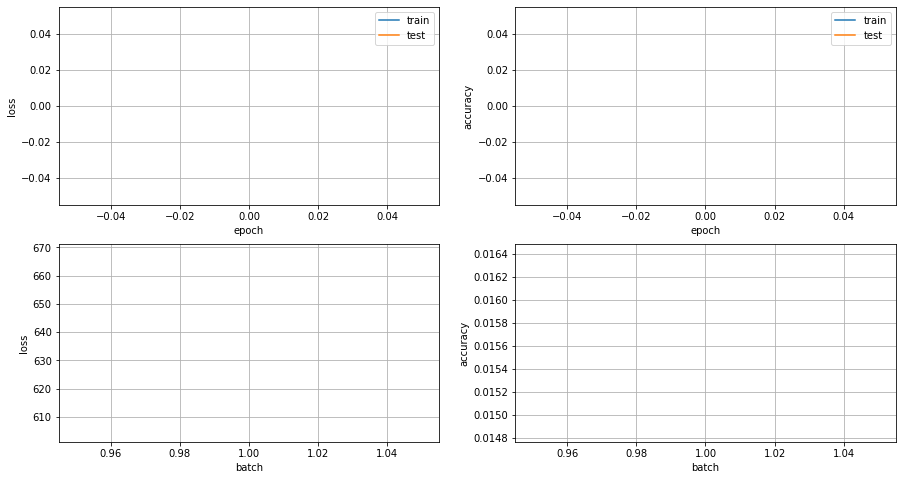

KeyboardInterrupt: 

In [26]:
from torch.optim.lr_scheduler import MultiStepLR
start_epoch = 60
RESUME = False
criterion = nn.CrossEntropyLoss()

n_epochs = 180
save_epoch = 40
p_grid= [0.9, 0.8, 0.7, 0.6, 1]

stats = []
for p in p_grid:
    if RESUME:
        pass
        # start_epoch, model, optimizer, train_losses, test_losses, train_acc, test_acc = load_checkpoint()
    else:
        model = resnet20_TTRL(device, p=p, rank='same', in_ttrl_shape=(4, 4, 4, 8, 8), out_ttrl_shape=(2, 5, 2, 5, 1)).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4, momentum=0.9)
        train_losses, test_losses, train_acc, test_acc = [], [], [], []
        start_epoch = 0
    
    import os
    dir_path = f'trained_models/'
    os.makedirs(dir_path, exist_ok=True)
    save_path = dir_path + f'TTRL-p-{p}'

    milestones = [80, 120]
    scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
    cur_train_losses, cur_test_losses, cur_train_accuracies, cur_test_accuracies = train(train_losses, test_losses, train_acc, test_acc)
    stats.append({'train_losses' : cur_train_losses,
                'test_losses' : cur_test_losses,
                'train_accuracies' : cur_train_accuracies,
                'test_accuracies' : cur_test_accuracies})
    RESUME = False